In [1]:
import torch
import numpy as np
import torch
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import torchvision.transforms as T
from torchvision.models.optical_flow import raft_large
from torchvision.io import read_video

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/Data/chen.ruikai/CV/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
model = raft_large(pretrained=True, progress=False).to(device)
model = model.eval()

/Data/chen.ruikai/CV/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Data/chen.ruikai/CV/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=Raft_Large_Weights.C_T_SKHT_V2`. You can also use `weights=Raft_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [3]:
video_path = "./data/generated/block0_zoom-in-pan-left/prompt_0_video_0.mp4"

In [4]:
frames, _, _ = read_video(str(video_path))
frames = frames.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
frames[0]

/Data/chen.ruikai/CV/lib/python3.9/site-packages/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


tensor([[[103,  92, 114,  ..., 175, 174, 155],
         [ 93,  98, 106,  ..., 188, 173, 159],
         [ 89, 112, 107,  ..., 161, 175, 159],
         ...,
         [ 65,  75,  87,  ..., 158, 158, 162],
         [ 73,  85,  98,  ..., 164, 165, 170],
         [ 75,  74,  94,  ..., 170, 172, 177]],

        [[100,  89, 111,  ..., 166, 165, 146],
         [ 90,  95, 103,  ..., 179, 164, 150],
         [ 86, 109, 104,  ..., 152, 166, 150],
         ...,
         [ 94, 104, 116,  ..., 170, 170, 174],
         [103, 115, 128,  ..., 172, 173, 178],
         [105, 104, 124,  ..., 178, 180, 185]],

        [[147, 136, 158,  ..., 192, 191, 172],
         [137, 142, 150,  ..., 205, 190, 176],
         [133, 156, 151,  ..., 178, 192, 176],
         ...,
         [ 25,  35,  47,  ...,  13,  11,  15],
         [ 27,  39,  52,  ...,  10,   9,  14],
         [ 29,  28,  48,  ...,  16,  16,  21]]], dtype=torch.uint8)

In [5]:
plt.rcParams["savefig.bbox"] = "tight"
# sphinx_gallery_thumbnail_number = 2


def plot(imgs, **imshow_kwargs):
    if not isinstance(imgs[0], list):
        # Make a 2d grid even if there's just 1 row
        imgs = [imgs]

    num_rows = len(imgs)
    num_cols = len(imgs[0])
    _, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
    for row_idx, row in enumerate(imgs):
        for col_idx, img in enumerate(row):
            ax = axs[row_idx, col_idx]
            img = F.to_pil_image(img.to("cpu"))
            ax.imshow(np.asarray(img), **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

    plt.tight_layout()

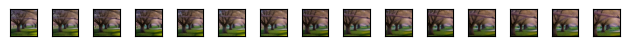

In [6]:
img1_batch = torch.stack([frames[i] for i in range(15)])
img2_batch = torch.stack([frames[i] for i in range(1,16)])

plot(img1_batch)

In [7]:
def preprocess(batch):
    transforms = T.Compose(
        [
            T.ConvertImageDtype(torch.float32),
            T.Normalize(mean=0.5, std=0.5),  # map [0, 256] into [-1, 1]
            T.Resize(size=(256, 256)),
        ]
    )
    batch = transforms(batch)
    return batch

img1_batch = preprocess(img1_batch).to(device)
img2_batch = preprocess(img2_batch).to(device)

print(f"shape = {img1_batch.shape}, dtype = {img1_batch.dtype}")

shape = torch.Size([15, 3, 256, 256]), dtype = torch.float32


In [8]:
list_of_flows = model(img1_batch.to(device), img2_batch.to(device))
print(f"type = {type(list_of_flows)}")
print(f"length = {len(list_of_flows)} = number of iterations of the model")

type = <class 'list'>
length = 12 = number of iterations of the model


In [9]:
predicted_flows = list_of_flows[-1]
print(f"dtype = {predicted_flows.dtype}")
print(f"shape = {predicted_flows.shape} = (N, 2, H, W)")
print(f"min = {predicted_flows.min()}, max = {predicted_flows.max()}")

dtype = torch.float32
shape = torch.Size([15, 2, 256, 256]) = (N, 2, H, W)
min = -13.285857200622559, max = 5.739569664001465


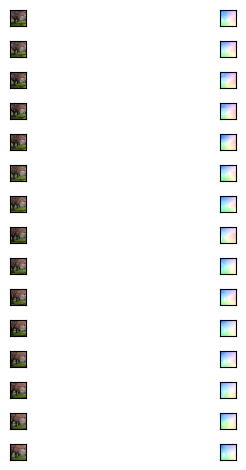

In [10]:
from torchvision.utils import flow_to_image

flow_imgs = flow_to_image(predicted_flows)

# The images have been mapped into [-1, 1] but for plotting we want them in [0, 1]
img1_batch = [(img1 + 1) / 2 for img1 in img1_batch]

grid = [[img1, flow_img] for (img1, flow_img) in zip(img1_batch, flow_imgs)]
plot(grid)